## Chapter 8

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

### Example 8.1
Empirical covariance matrix and spurious correlations for different ensemble sizes

In [55]:
Nz = 10
ensemble = [11,20,30,40,50,60,70,80,90,100,250,500,750,1000,2000]

J = len(ensemble)
# For each ensemble size, we want to repeat the experiment 1000 times
Aver = 1000

D = np.zeros((J))
C = np.zeros((J,Nz))

for j in range(J):
    M = ensemble[j]
    
    e = np.ones(M)
    
    for jj in range(Aver):
        # Ensemble of size M with N dimensions for each member
        X = np.random.randn(Nz,M)
        X -= X.mean(axis=1).reshape(-1,1)
        P = 1./(M-1) * np.dot(X,X.T)
        
        # Want to find determinant of P. SVD decomposition gives U, S, V. det(U) and det(V) = +/-1,
        # while det(S) = prod(S), then det(P) = prod(S)
        _,S,_ = np.linalg.svd(P)
        
        D[j] += np.prod(S)**(1./Nz)
        
        # equation 8.2
        eye = np.eye(P.shape[0], dtype=bool)
        P_offdiag = np.copy(P)
        P_offdiag[np.where(eye == True)] = 0.
        C[j,:] += 1./(Nz-1.) * np.abs(P_offdiag).sum(axis=0)
        
D /= Aver
C /= Aver
C = C.mean(axis=1)

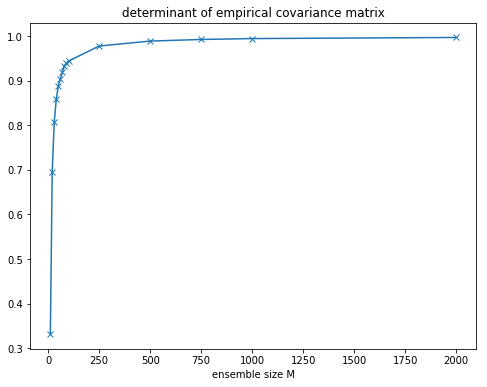

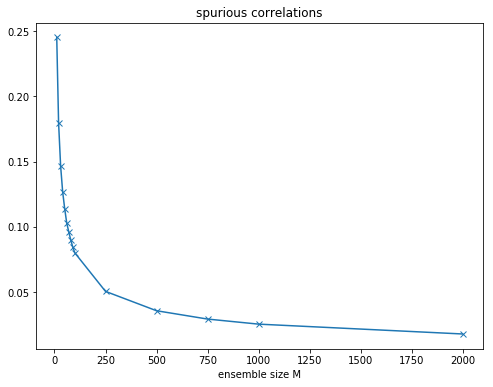

In [57]:
fig0a = plt.figure(figsize=(8,6))
plt.plot(ensemble,D, '-x')
plt.xlabel("ensemble size M")
plt.title("determinant of empirical covariance matrix")
plt.show()

fig0b = plt.figure(figsize=(8,6))
plt.plot(ensemble,C, '-x')
plt.xlabel("ensemble size M")
plt.title("spurious correlations")
plt.show()

### Example 8.4 (Linear advection and method of characteristics)

In [100]:
Dx = 0.01
Dt = 0.001

x = np.linspace(0.,1.,100)
t = np.linspace(0.,4.,4000)

xx, tt = np.meshgrid(x,t)

xk = np.zeros((t.shape[0],x.shape[0]))
xk[0,:] = xx[0,:]
U = np.sin(2.*np.pi*xx)
# forward Euler

for step in range(t.shape[0] - 1):
    xk[step+1,:] = xk[step,:] + Dt * np.sin(2.*np.pi*xk[step,:]) * np.cos(np.pi*tt[step])
    

In [151]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook

fig1 = plt.figure(figsize=(8,6))
ax = fig1.add_subplot(111, projection='3d')
ax.set_xlabel("space")
ax.set_ylabel("time")
surf = ax.plot_surface(xk,tt,U, cmap=cm.Spectral_r, edgecolors='k',rstride=4, cstride=4, alpha=1, antialiased=True,linewidth=0.1)
plt.show()

<IPython.core.display.Javascript object>

TypeError: integer argument expected, got float

### Example 8.5 (Upwind scheme for linear advection)